# Sparse LVGP for modeling formation energies for $ABO_3$ perovskites

In ths notebook, we will model the (DFT computed) formation energies of $ABO_3$ perovskites as a function of the composition - choice of elements for the $A$ and $B$ atoms - using LVGP models with sparse approximations. There are 73 elements from the periodic table that can occupy either of these sites. The dataset contains a total of 5276 compounds for which formation energies are available. 

In [1]:
import time
import torch
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lvgp_bayes.models.sparselvgp import SparseLVGPR
from lvgp_bayes.utils.variables import CategoricalVariable
from lvgp_bayes.utils.input_space import InputSpace
from lvgp_bayes.optim import fit_model_scipy
from lvgp_bayes.utils.metrics import rrmse,mean_interval_score,coverage

from copy import deepcopy

plt.rcParams['figure.dpi']=150
plt.rcParams['font.family']='serif'

In [2]:
def set_seed(seed:int):
    random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)

In [3]:
dat = pd.read_csv('../experiments/abo3/ABO3perovskites.csv',na_values='-')
dat = dat[~dat['Formation energy [eV/atom]'].isna()]
dat.columns

Index(['Chemical formula', 'A', 'B', 'In literature', 'Valence A', 'Valence B',
       'Radius A [ang]', 'Radius B [ang]', 'Lowest distortion',
       'Formation energy [eV/atom]', 'Stability [eV/atom]',
       'Magnetic moment [mu_B]', 'Volume per atom [A^3/atom]', 'Band gap [eV]',
       'a [ang]', 'b [ang]', 'c [ang]', 'alpha [deg]', 'beta [deg]',
       'gamma [deg]', 'Vacancy energy [eV/O atom]'],
      dtype='object')

In [4]:
cols = ['A','B']
levels_list = [
    sorted(dat[col].unique().tolist()) for col in cols
]

config = InputSpace()
config.add_inputs([
    CategoricalVariable(col,levels=levels) \
    for col,levels in zip(cols,levels_list)
])

config

Input space with variables:

A, Type: Categorical, Levels: {Ac, Ag, Al, As, Au, B, Ba, Be, Bi, Ca, Cd, Ce, Co, Cr, Cs, Cu, Dy, Er, Eu, Fe, Ga, Gd, Ge, Hf, Hg, Ho, In, Ir, K, La, Li, Lu, Mg, Mn, Mo, Na, Nb, Nd, Ni, Np, Os, Pa, Pb, Pd, Pm, Pr, Pt, Pu, Rb, Re, Rh, Ru, Sb, Sc, Si, Sm, Sn, Sr, Ta, Tb, Tc, Te, Th, Ti, Tl, Tm, U, V, W, Y, Yb, Zn, Zr}
B, Type: Categorical, Levels: {Ac, Ag, Al, As, Au, B, Ba, Be, Bi, Ca, Cd, Ce, Co, Cr, Cs, Cu, Dy, Er, Eu, Fe, Ga, Gd, Ge, Hf, Hg, Ho, In, Ir, K, La, Li, Lu, Mg, Mn, Mo, Na, Nb, Nd, Ni, Np, Os, Pa, Pb, Pd, Pm, Pr, Pt, Pu, Rb, Re, Rh, Ru, Sb, Sc, Si, Sm, Sn, Sr, Ta, Tb, Tc, Te, Th, Ti, Tl, Tm, U, V, W, Y, Yb, Zn, Zr}

In [5]:
# encode categorical variables as integers
# and scale numerical variables to the unit hypercube
all_x = torch.from_numpy(np.array([
    config.get_array_from_dict(row.to_dict())\
    for _,row in dat[config.get_variable_names()].iterrows()
]))

# response - formation energy
all_y = torch.from_numpy(dat['Formation energy [eV/atom]'].values)

print(all_x.shape)

torch.Size([5276, 2])


In [6]:
set_seed(2000)
num_train_samples = 1000 # 1000 training samples 
idxs_train = torch.from_numpy(np.random.choice(all_x.shape[0],size=num_train_samples))
idxs_test = torch.tensor([
    idx for idx in range(all_x.shape[0]) if idx not in idxs_train
])


train_x,train_y = all_x[idxs_train,:],all_y[idxs_train]
test_x,test_y = all_x[idxs_test,:],all_y[idxs_test]

## Sparse LVGP models

In this library, the sparse approximations to the LVGP likelihood using inducint points are implemented in the `SpasrseLVGPR` class. There are two different approximations available - the fully independent training conditional (FITC) and the variational free energy (VFE) methods. The two methods use slightly different approximating distributions and likelihood objectives, but have quite different performances in practice. In `SpasrseLVGPR`, the method can be specified through the `approx` argument. 


Among the two methods, FITC is less sensitive to initial guesses. Therefore, irrespective of the choice of the final model, we will always fit the model with the FITC approximation first, and use it to initialize optimization for the VFE model.

In [7]:
set_seed(2000)
model_fitc = SparseLVGPR(
    train_x=train_x,
    train_y=train_y,
    qual_index=config.qual_index,
    quant_index=config.quant_index,
    num_levels_per_var=list(config.num_levels.values()),
    lb_noise=1e-4,
    num_inducing=50,
    approx='FITC'
).double()

start_time = time.time()
# fit model with 15 different starts
reslist_fitc,nll_inc_fitc = fit_model_scipy(
    model_fitc,
    num_restarts=9, # number of starting points
    options={'ftol':1e-6,'maxfun':1000} # options to L-BFGS,
)
train_time_fitc = time.time()-start_time


print('****** FITC ******')
print(train_time_fitc)

with torch.no_grad():
    # set return_std = False if standard deviation is not needed 
    test_pred0,test_pred_std0 = model_fitc.predict(test_x,return_std=True)

# print RRMSE
lq,uq = test_pred0-1.96*test_pred_std0,test_pred0+1.96*test_pred_std0
stats_fitc = {
    'rrmse':rrmse(test_y,test_pred0).item(),
    'mis':mean_interval_score(test_y,lq,uq,0.05).item(),
    'coverage':coverage(test_y,lq,uq).item()
}
print(stats_fitc)

****** FITC ******
30.932891130447388
{'rrmse': 0.45784989579882707, 'mis': 2.954666858930513, 'coverage': 0.7410981059074402}


In [8]:
model_vfe = SparseLVGPR(
    train_x=train_x,
    train_y=train_y,
    qual_index=config.qual_index,
    quant_index=config.quant_index,
    num_levels_per_var=list(config.num_levels.values()),
    lb_noise=1e-4,
    num_inducing=50,
    approx='VFE'
).double()

# Initialize VFE from the FITC solution 
model_vfe.load_state_dict(deepcopy(model_fitc.state_dict()))


start_time = time.time()
# fit model with 15 different starts
reslist_vfe,nll_inc_vfe = fit_model_scipy(
    model_vfe,
    num_restarts=0, # number of starting points
    options={'ftol':1e-6,'maxfun':1000} # options to L-BFGS,
)
train_time_vfe= train_time_fitc+time.time()-start_time

print('\n****** VFE ******')
print(train_time_vfe)

with torch.no_grad():
    # set return_std = False if standard deviation is not needed 
    test_pred0,test_pred_std0 = model_vfe.predict(test_x,return_std=True)

# print RRMSE
lq,uq = test_pred0-1.96*test_pred_std0,test_pred0+1.96*test_pred_std0
stats_vfe = {
    'rrmse':rrmse(test_y,test_pred0).item(),
    'mis':mean_interval_score(test_y,lq,uq,0.05).item(),
    'coverage':coverage(test_y,lq,uq).item()
}
print(stats_vfe)


****** VFE ******
33.4489381313324
{'rrmse': 0.4432490123201206, 'mis': 7.967740674656414, 'coverage': 0.2942798137664795}


In [9]:
with torch.no_grad():
    print(model_fitc.raw_noise,model_vfe.raw_noise)

Parameter containing:
tensor([-12.0400], dtype=torch.float64, requires_grad=True) Parameter containing:
tensor([-2.8603], dtype=torch.float64, requires_grad=True)


We will now visualize the inducing points and the estimated latent variables in the LV space. Due to the differing approximations, the LVs spaces can be different with each approximation. 

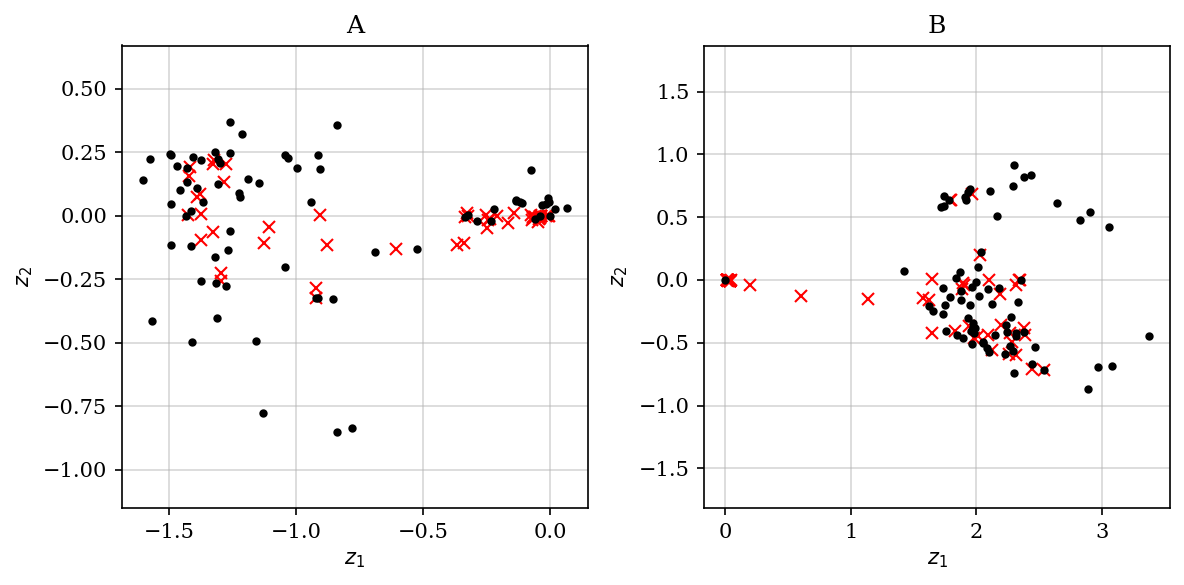

In [10]:
with torch.no_grad():
    qual_inducing = model_fitc.inducing_points()
    lvs_list = [layer.latents.clone() for layer in model_fitc.lv_mapping_layers]
    inducing_list = [
       qual_inducing[:,(2*i):(2*i+2)] for i in range(2)
    ]
    
fig,axs = plt.subplots(1,2,figsize=(8,4))
for idx in range(2):
    _ = axs[idx].plot(inducing_list[idx][:,0],inducing_list[idx][:,1],'rx') # inducing points
    _ = axs[idx].plot(lvs_list[idx][:,0],lvs_list[idx][:,1],'k.') # latents
    _ = axs[idx].set_aspect('equal','datalim')
    _ = axs[idx].set_xlabel(r'$z_1$')
    _ = axs[idx].set_ylabel(r'$z_2$')
    _ = axs[idx].grid(alpha=0.5)
    _ = axs[idx].set_title(config.get_variable_by_idx(idx).name)    
    
fig.tight_layout()

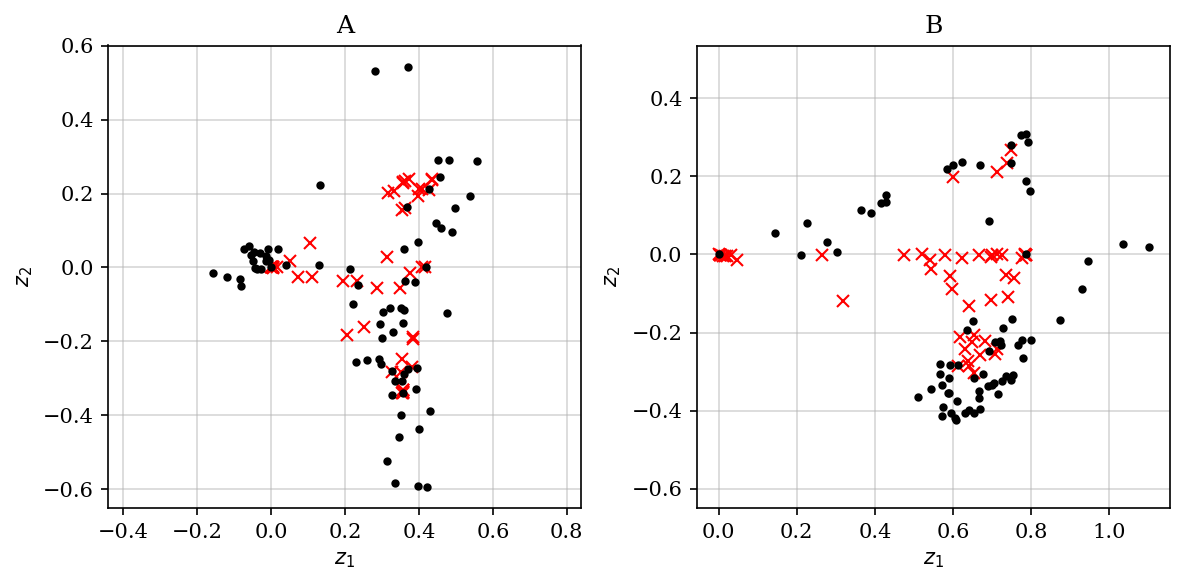

In [11]:
with torch.no_grad():
    qual_inducing = model_vfe.inducing_points()
    lvs_list = [layer.latents.clone() for layer in model_vfe.lv_mapping_layers]
    inducing_list = [
       qual_inducing[:,(2*i):(2*i+2)] for i in range(2)
    ]
    
fig,axs = plt.subplots(1,2,figsize=(8,4))
for idx in range(2):
    _ = axs[idx].plot(inducing_list[idx][:,0],inducing_list[idx][:,1],'rx') # inducing points
    _ = axs[idx].plot(lvs_list[idx][:,0],lvs_list[idx][:,1],'k.') # latents
    _ = axs[idx].set_aspect('equal','datalim')
    _ = axs[idx].set_xlabel(r'$z_1$')
    _ = axs[idx].set_ylabel(r'$z_2$')
    _ = axs[idx].grid(alpha=0.5)
    _ = axs[idx].set_title(config.get_variable_by_idx(idx).name)    
    
fig.tight_layout()